In [ ]:
!pip install opencv-python
!pip install pillow
!pip install matplotlib

importing required libaries

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

Displaying the first image

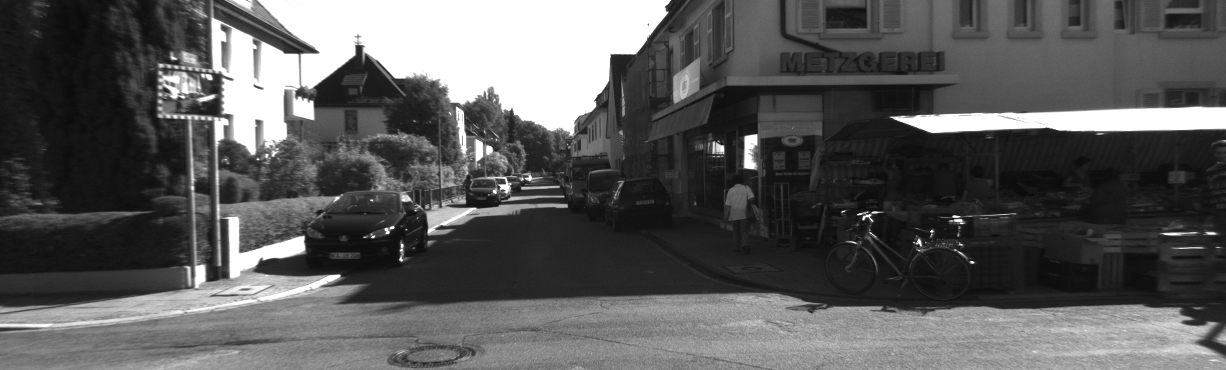

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

img1 = cv2.imread('/content/000000.png')
img2 = cv2.imread('/content/000023.png')
cv2_imshow(img1)

displaying the second image

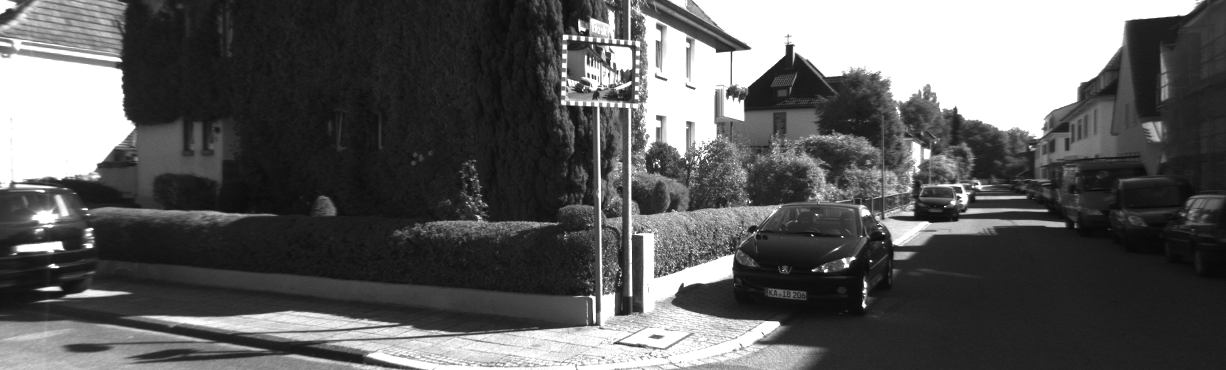

In [ ]:
cv2_imshow(img2)

pre-defined fundamental matrix

In [ ]:
F=[[3.34638533e-07,  7.58547151e-06, -2.04147752e-03],
   [-5.83765868e-06,  1.36498636e-06, 2.67566877e-04],
   [1.45892349e-03, -4.37648316e-03,  1.00000000e+00]]
F=np.array(F)

utilising an ORB to iterate through each descriptor of the first image to find the best match in the descriptors of the second image based on the euclidean distance

In [ ]:
orb = cv2.ORB_create()
keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

matches = []
for i in range(len(descriptors1)):
    best_match_idx = -1
    best_match_dist = float('inf')
    for j in range(len(descriptors2)):
        dist = np.linalg.norm(descriptors1[i] - descriptors2[j])
        if dist < best_match_dist:
            best_match_idx = j
            best_match_dist = dist
    matches.append(cv2.DMatch(i, best_match_idx, 0))

displaying epipolar lines of img 1 by img 2

Epipolar Lines on Image 1 formed by points on Image 2 :  [[ 1.8649284e-02 -9.9982607e-01  2.6232712e+02]
 [ 9.7287256e-01  2.3134169e-01 -1.6589519e+02]
 [ 9.7709543e-01  2.1280162e-01 -1.6144815e+02]
 ...
 [ 2.0341457e-01  9.7909272e-01 -2.8075150e+02]
 [ 6.2455112e-01  7.8098392e-01 -2.7371207e+02]
 [ 2.9882950e-01  9.5430654e-01 -2.8447025e+02]]


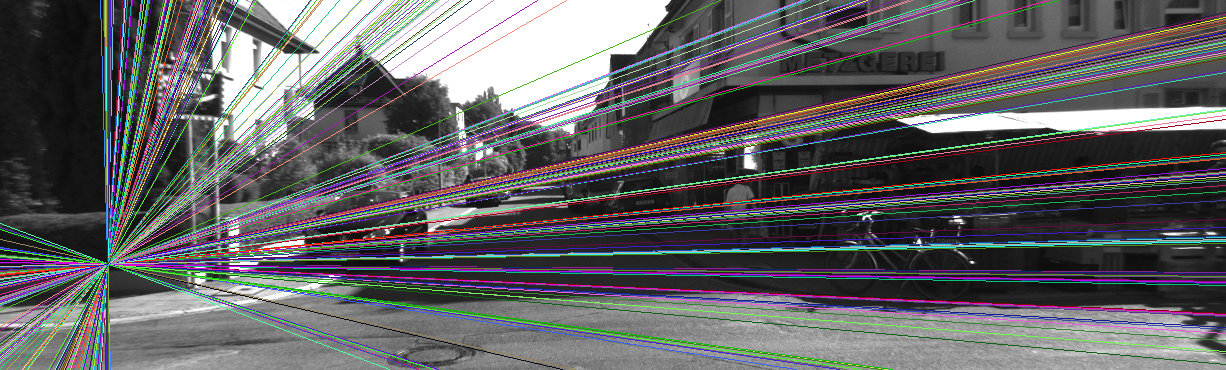

In [ ]:
matches = sorted(matches, key = lambda x:x.distance)
points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

lines1 = cv2.computeCorrespondEpilines(points2, 2, F)
lines1 = lines1.reshape(-1, 3)
lines2 = cv2.computeCorrespondEpilines(points1, 1, F)
lines2 = lines2.reshape(-1, 3)
def draw_epilines(img, lines):
    for line in lines:
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -line[2]/line[1]])
        x1, y1 = map(int, [img.shape[1], -(line[2]+line[0]*img.shape[1])/line[1]])
        img = cv2.line(img, (x0, y0), (x1, y1), color, 1)
    return img

Epipolar_lines_1 = draw_epilines(img1.copy(), lines1)
Epipolar_lines_2 = draw_epilines(img2.copy(), lines2)
print("Epipolar Lines on Image 1 formed by points on Image 2 : ", lines1)
cv2_imshow(Epipolar_lines_1)

vice-versa of above

Epipolar Lines on Image 2 formed by points on Image 1 :  [[-7.5861686e-01 -6.5153700e-01  5.8194727e+02]
 [-7.3137522e-01 -6.8197531e-01  5.7612891e+02]
 [-1.9600503e-01 -9.8060286e-01  3.7787387e+02]
 ...
 [-6.3577092e-01 -7.7187777e-01  5.5096991e+02]
 [-3.6601841e-01 -9.3060762e-01  4.5339120e+02]
 [-3.5926190e-01 -9.3323678e-01  4.5056995e+02]]


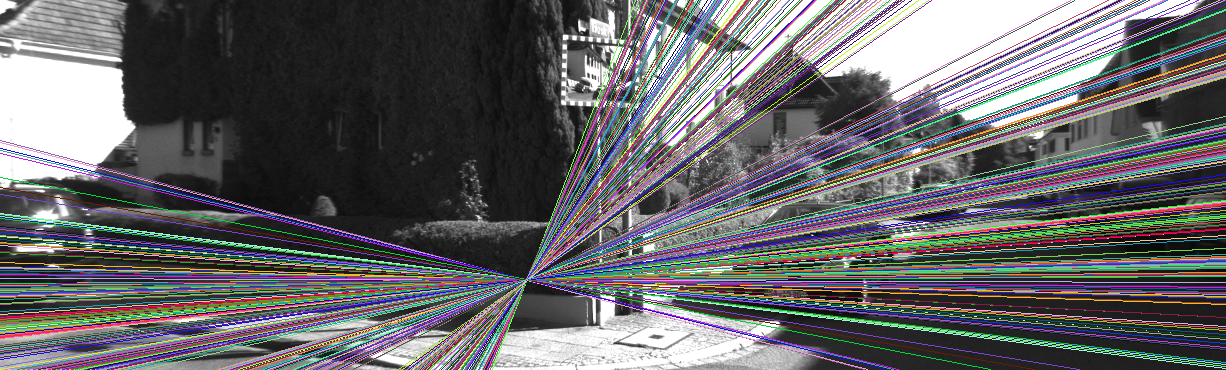

In [ ]:
print("Epipolar Lines on Image 2 formed by points on Image 1 : ", lines2)
cv2_imshow(Epipolar_lines_2)

In [ ]:
def draw_epilines_points(img, points):
    for pt in points:
        color = (0,0, 255)
        img = cv2.circle(img, (int(pt[0][0]), int(pt[0][1])), 3, color, -1)
    return img

highlighting the epilines points

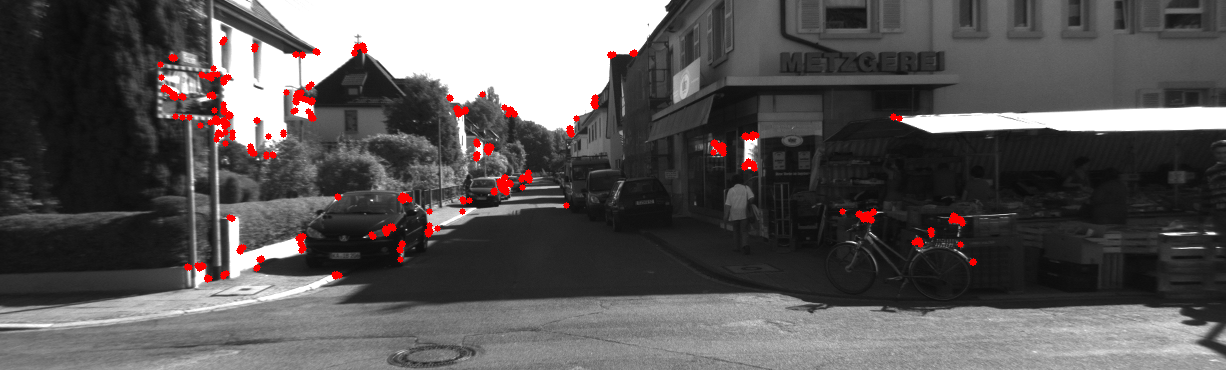

In [ ]:
image1_with_points = draw_epilines_points(img1.copy(),points1)
image2_with_points = draw_epilines_points(img2.copy(), points2)
cv2_imshow(image1_with_points)

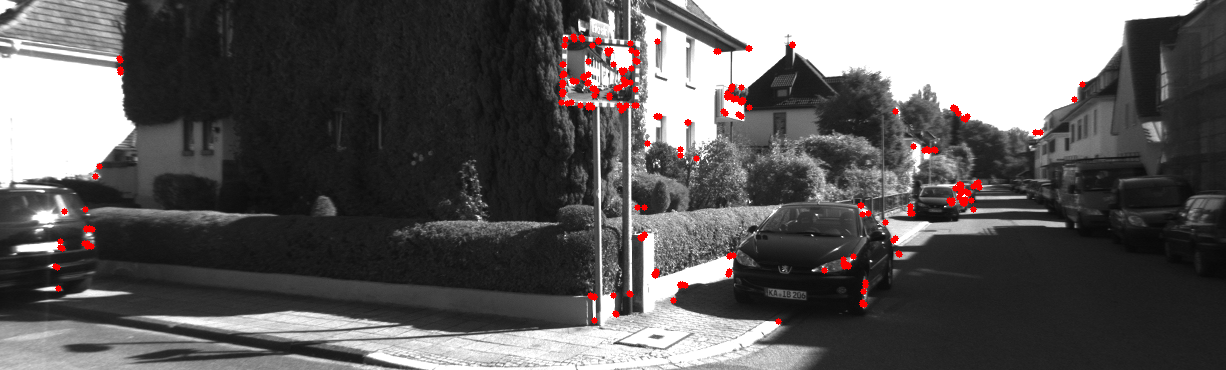

In [ ]:
cv2_imshow(image2_with_points)

function to compute the intersection points between a line and a rectangle used afterwards

In [ ]:
def line_rectangle_intersection(a, b, c, w, h):
    def is_inside(x, y):
        return 0 <= x <= w and 0 <= y <= h

    def find_intersection_points():
        intersections = []
        x = 0
        y = -c / b
        if is_inside(x, y):
            intersections.append((x, y))

        x = w
        y = (-c - a * w) / b
        if is_inside(x, y):
            intersections.append((x, y))

        y = 0
        x = -c / a
        if is_inside(x, y):
            intersections.append((x, y))

        y = h
        x = (-c - b * h) / a
        if is_inside(x, y):
            intersections.append((x, y))

        return intersections
    intersections = find_intersection_points()

    return intersections

I found the first line's intersection points with the image boundaries, drew the line on a copy of the first image, and finally encircled along the line at intervals of 10 percent

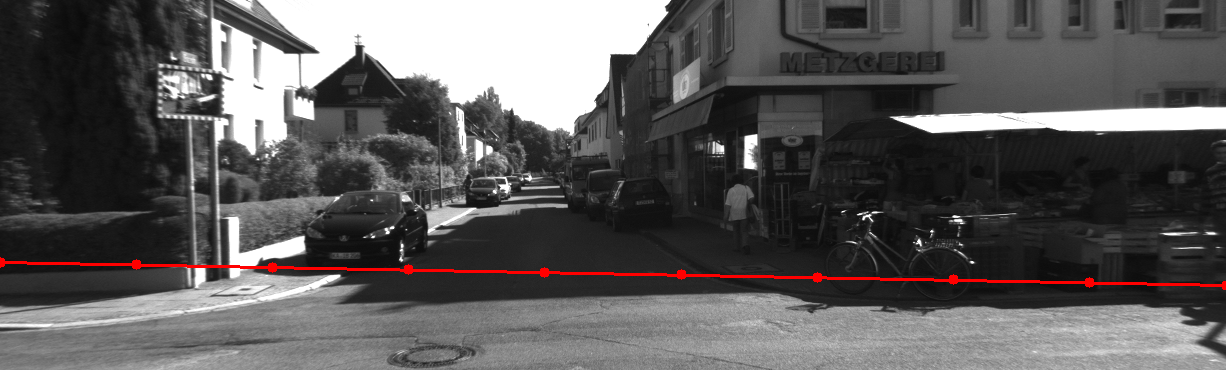

In [ ]:
selected_lines = lines1[:1]

I1=img1.copy()
line_points=[]
for r in selected_lines:
        line_point_l=[]
        color = (0,0,255)
        intersections = line_rectangle_intersection(r[0], r[1], r[2], img1.shape[1], img1.shape[0])
        x0=int(intersections[0][0])
        y0=int(intersections[0][1])
        x1=int(intersections[1][0])
        y1=int(intersections[1][1])
        cv2.line(I1, (x0,y0), (x1,y1), color, 2)
        x_values = np.linspace(x0, x1, 10)
        y_values = np.linspace(y0, y1, 10)
        for x, y in zip(x_values, y_values):
            line_point_l.append((x,y))
            cv2.circle(I1, (int(x), int(y)), 5, color, -1)
        line_points.append(line_point_l)

cv2_imshow(I1)

same as above; here i utilise the second image

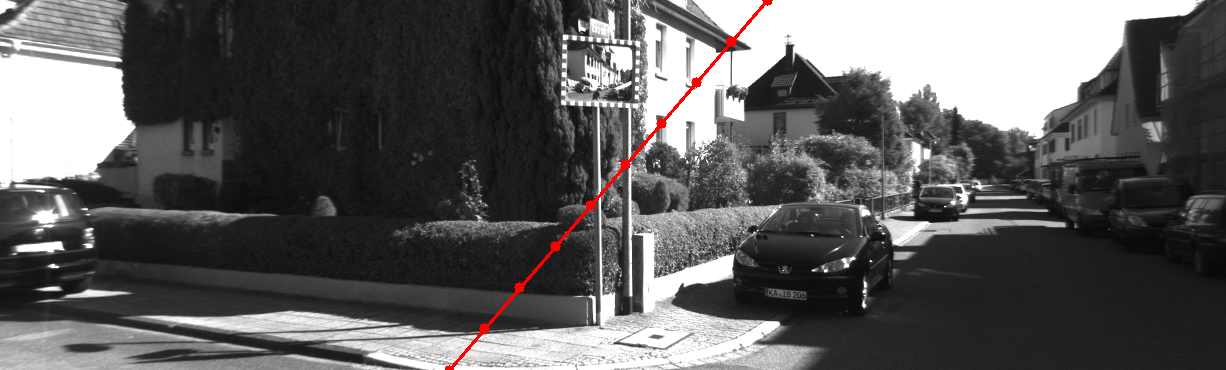

In [ ]:
selected_lines = lines2[:1]
I2=img2.copy()
for r in selected_lines:
        line_point_l=[]
        color = (0,0,255)
        intersections = line_rectangle_intersection(r[0], r[1], r[2], img2.shape[1], img2.shape[0])
        x0=int(intersections[0][0])
        y0=int(intersections[0][1])
        x1=int(intersections[1][0])
        y1=int(intersections[1][1])
        cv2.line(I2, (x0,y0), (x1,y1), color, 2)
        x_values = np.linspace(x0, x1, 10)
        y_values = np.linspace(y0, y1, 10)
        for x, y in zip(x_values, y_values):
            line_point_l.append((x,y))
            cv2.circle(I2, (int(x), int(y)), 5, color, -1)
        line_points.append(line_point_l)

cv2_imshow(I2)

In [ ]:
line_points

[[(0.0, 262.0),
  (136.22222222222223, 264.55555555555554),
  (272.44444444444446, 267.1111111111111),
  (408.6666666666667, 269.6666666666667),
  (544.8888888888889, 272.22222222222223),
  (681.1111111111111, 274.77777777777777),
  (817.3333333333334, 277.3333333333333),
  (953.5555555555557, 279.8888888888889),
  (1089.7777777777778, 282.44444444444446),
  (1226.0, 285.0)],
 [(767.0, 0.0),
  (731.6666666666666, 41.111111111111114),
  (696.3333333333334, 82.22222222222223),
  (661.0, 123.33333333333334),
  (625.6666666666666, 164.44444444444446),
  (590.3333333333333, 205.55555555555557),
  (555.0, 246.66666666666669),
  (519.6666666666666, 287.7777777777778),
  (484.3333333333333, 328.8888888888889),
  (449.0, 370.0)]]

In [ ]:
line_points[0] = np.array(line_points[0])
line_points[1] = np.array(line_points[1])
lines1 = cv2.computeCorrespondEpilines(line_points[0], 2, F)
lines1 = lines1.reshape(-1, 3)
lines2 = cv2.computeCorrespondEpilines(line_points[1],1, F)
lines2 = lines2.reshape(-1, 3)

### Displaying the epipolar lines finally

In [ ]:
def draw_epilines(img, lines):
    for line in lines:
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -line[2]/line[1]])
        x1, y1 = map(int, [img.shape[1], -(line[2]+line[0]*img.shape[1])/line[1]])
        img = cv2.line(img, (x0, y0), (x1, y1), color, 1)
    return img

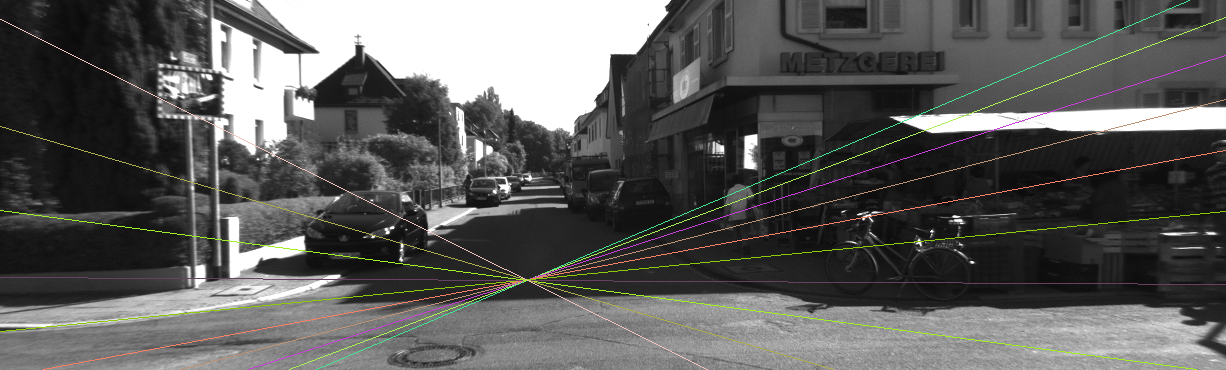

In [ ]:
Epipolar_lines_1 = draw_epilines(img1.copy(), lines2)
Epipolar_lines_2 = draw_epilines(img2.copy(), lines1)
cv2_imshow(Epipolar_lines_1)

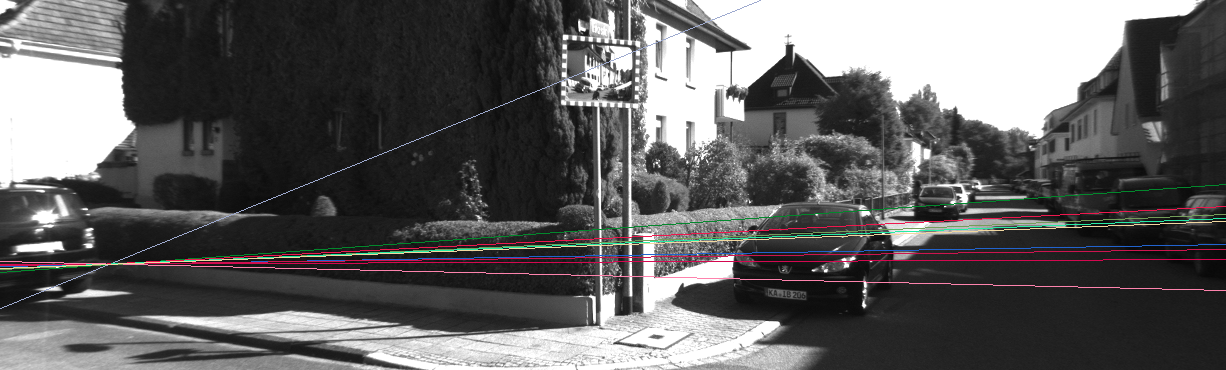

In [ ]:
cv2_imshow(Epipolar_lines_2)